The goal is to compare OHLCV data from the prod DB that the prod DAG sees with that from the Binance terminal.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import logging

import pandas as pd

import dataflow.core as dtfcore
import helpers.hdatetime as hdateti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import im_v2.ccxt.data.client.ccxt_clients as imvcdccccl
import im_v2.common.data.client.im_raw_data_client as imvcdcimrdc
import im_v2.common.db.db_utils as imvcddbut
import im_v2.common.universe as ivcu
import im_v2.common.universe.universe_utils as imvcuunut
import market_data as mdata

/app/amp/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-d99d4ced-b307-4968-8ad8-b27ff236b1c9.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.4.2' != container_version='1.4.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask4275_check_prod_ohlcv_data_against_binance'
  hash='30d7d5696'
  # Last commits:
    * 30d7d5696 PomazkinG checkpoint                                                        (12 minutes ago) Fri May 12 11:44:55 2023  (HEAD -> CmTask4275_check_prod_ohlcv_data_against_binance)
    * 9a7f8bf19 PomazkinG checkpoint                                                        (    4 days ago) Mon May 8 15:27:15 2023  (origin/CmTas

# Compare OHLCV data (prod CK vs Binance)

In [3]:
def get_ccxt_prod_market_data(universe_version: str) -> mdata.MarketData:
    """
    Get `MarketData` backed by the production DB.

    :param universe_version: universe version, e.g., "v7.1"
    """
    vendor = "CCXT"
    mode = "trade"
    as_full_symbol = True
    full_symbols = ivcu.get_vendor_universe(
        vendor,
        mode,
        version=universe_version,
        as_full_symbol=as_full_symbol,
    )
    asset_ids = [
        ivcu.string_to_numerical_id(full_symbol) for full_symbol in full_symbols
    ]
    universe_version = "infer_from_data"
    # Get DB connection.
    db_connection = imvcddbut.DbConnectionManager.get_connection("prod")
    # Get the real-time `ImClient`.
    table_name = "ccxt_ohlcv_futures"
    resample_1min = False
    im_client = imvcdccccl.CcxtSqlRealTimeImClient(
        universe_version, db_connection, table_name, resample_1min=resample_1min
    )
    # Get the real-time `MarketData`.
    market_data, _ = mdata.get_RealTimeImClientMarketData_example1(
        im_client, asset_ids
    )
    return market_data


def load_btc_market_data(
    market_data: mdata.MarketData,
    start_ts: pd.Timestamp,
    end_ts: pd.Timestamp,
    apply_timing_fix: bool,
) -> pd.DataFrame:
    """
    Load OHLCV data for BTC_USDT perpetual futures.

    :param market_data: `MarketData` backed by the production DB
    :param start_ts: start of the interval of interest
    :param end_ts: end of the interval of interest
    :param apply_timing_fix: convert timestamp from the start of a bar
        to the end of a bar if True otherwise pass
    :return: OHLCV data for BTC_USDT
    """
    if apply_timing_fix:
        start_ts = start_ts - pd.Timedelta(minutes=1)
        end_ts = end_ts - pd.Timedelta(minutes=1)
    timestamp_col_name = "timestamp"
    asset_ids = None
    df = market_data.get_data_for_interval(
        start_ts, end_ts, timestamp_col_name, asset_ids
    )
    if apply_timing_fix:
        df.index = df.index + pd.Timedelta(minutes=1)
    # Convert to Binance timezone.
    df.index = df.index.tz_convert("UTC")
    # Keep only BTC_USDT as an example.
    df_btc = df[df["full_symbol"] == "binance::BTC_USDT"]
    return df_btc

In [4]:
# Get the `MarketData` backed by the prod DB.
universe_version = "v7.1"
prod_market_data = get_ccxt_prod_market_data(universe_version)

INFO  Unable to fetch DB credentials from environment variables: 
	'POSTGRES_HOST'
	Attempting env file method.
INFO  Unable to fetch DB credentials from env file: 
	
################################################################################
* Failed assertion *
File '/app/amp/im_v2/devops/env/prod.im_db_config.env' doesn't exist
################################################################################

	Attempting AWS SecretsManager method.
INFO  Fetching secret: prod.im_data_db.read_only
INFO  Created prod DB connection: 
 <connection object at 0x7f28cb5dc540; dsn: 'user=ck_prod_read_only password=xxx dbname=prod.im_data_db host=prod-im-db.cpox8ul7pzan.eu-north-1.rds.amazonaws.com port=5432', closed: 0>


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Get binance OHLCV data from https://www.binance.com/en/futures/BTCUSDT. The timestamp is in UTC+4 timezone.

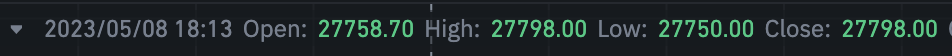

CK OHLCV data without the timing fix matches that from the Binance terminal.

In [5]:
start_ts = pd.Timestamp("2023-05-08 14:13:00+00:00")
end_ts = pd.Timestamp("2023-05-08 14:14:00+00:00")
apply_timing_fix = False
btc_ohlcv_data = load_btc_market_data(
    prod_market_data, start_ts, end_ts, apply_timing_fix
)
btc_ohlcv_data

/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


,asset_id,id,open,high,low,close,volume,end_download_timestamp,knowledge_timestamp,full_symbol,start_timestamp
end_timestamp,,,,,,,,,,,
2023-05-08 14:13:00+00:00,1467591036,157612076,27758.7,27798.0,27750.0,27798.0,571.778,2023-05-08 14:14:10.014917+00:00,2023-05-08 14:14:10.091106+00:00,binance::BTC_USDT,2023-05-08 10:12:00-04:00


To account for the fact that:
- Binance timestamp is the start of a 1-minute bar
- CK timestamp is the end of 1-minute bar

We should apply the timing fix such that data timestamp 14:13 (start of the bar) becomes 14:14 (end of the bar).

In [6]:
start_ts = pd.Timestamp("2023-05-08 14:13:00+00:00")
end_ts = pd.Timestamp("2023-05-08 14:15:00+00:00")
apply_timing_fix = True
btc_ohlcv_data_with_timing_fix = load_btc_market_data(
    prod_market_data, start_ts, end_ts, apply_timing_fix
)
btc_ohlcv_data_with_timing_fix

/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


,asset_id,id,open,high,low,close,volume,end_download_timestamp,knowledge_timestamp,full_symbol,start_timestamp
end_timestamp,,,,,,,,,,,
2023-05-08 14:13:00+00:00,1467591036,157611785,27759.1,27769.8,27755.0,27758.8,465.357,2023-05-08 14:13:10.013422+00:00,2023-05-08 14:13:10.034714+00:00,binance::BTC_USDT,2023-05-08 10:11:00-04:00
2023-05-08 14:14:00+00:00,1467591036,157612076,27758.7,27798.0,27750.0,27798.0,571.778,2023-05-08 14:14:10.014917+00:00,2023-05-08 14:14:10.091106+00:00,binance::BTC_USDT,2023-05-08 10:12:00-04:00


# Check DAG prices vs binance prices

As one can see: DAG prices are binance prices shifted 1 minute forward which confirms that all works as it should.

## DAG prices

In [7]:
# Paper trading system run with the timing issue fix.
dag_dir = "/shared_data/ecs/preprod/system_reconciliation/C3a/20230511/system_log_dir.scheduled.20230511_131000.20230512_130500/dag/node_io/node_io.data"
node_name = "predict.0.read_data"
bar_timestamp = pd.Timestamp("2023-05-12 06:40:00")
df = dtfcore.get_dag_node_output(dag_dir, node_name, bar_timestamp)
df.tail(5)["close"]

,1030828978,1464553467,1467591036,1528092593,1776791608,1891737434,1966583502,2099673105,2237530510,2384892553,2425308589,2476706208,2484635488,2540896331,2601760471,2683705052,3065029174,3401245610,4516629366,5115052901,5118394986,6051632686,8717633868,8968126878,9872743573
end_timestamp,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-12 06:36:00-04:00,0.2660,1766.04,26353.8,0.1456,4.085,5.238,0.3695,1.167,20.279,1.5378,0.3015,0.802,0.0886,6.677,6.416,0.8453,0.07221,2.065,0.4910,0.7277,0.4281,3.203,14.976,305.53,1.577
2023-05-12 06:37:00-04:00,0.2660,1766.24,26349.2,0.1456,4.080,5.235,0.3690,1.166,20.264,1.5367,0.3015,0.803,0.0886,6.672,6.412,0.8453,0.07225,2.064,0.4907,0.7274,0.4279,3.201,14.974,305.49,1.576
2023-05-12 06:38:00-04:00,0.2660,1766.05,26350.1,0.1455,4.078,5.233,0.3690,1.165,20.261,1.5371,0.3015,0.803,0.0886,6.671,6.411,0.8453,0.07217,2.061,0.4909,0.7278,0.4282,3.200,14.972,305.48,1.575
2023-05-12 06:39:00-04:00,0.2661,1766.57,26355.9,0.1456,4.085,5.232,0.3691,1.166,20.271,1.5376,0.3015,0.803,0.0887,6.671,6.417,0.8457,0.07214,2.062,0.4910,0.7281,0.4281,3.201,14.970,305.46,1.576
2023-05-12 06:40:00-04:00,0.2661,1766.16,26355.8,0.1455,4.082,5.232,0.3687,1.167,20.258,1.5366,0.3016,0.803,0.0886,6.670,6.414,0.8452,0.07205,2.062,0.4910,0.7280,0.4283,3.201,14.964,305.49,1.576


## Binance prices as-is from the `RawDataReader`

In [8]:
# Get the prod universe as `full_symbols`.
universe_version = "v7.1"
vendor = "CCXT"
mode = "trade"
as_full_symbol = True
full_symbols = ivcu.get_vendor_universe(
    vendor,
    mode,
    version=universe_version,
    as_full_symbol=as_full_symbol,
)

In [9]:
# Use real-time data from the prod DB.
signature = "periodic_daily.airflow.downloaded_1min.postgres.ohlcv.futures.v7.ccxt.binance.v1_0_0"
start_timestamp = pd.Timestamp("2023-05-12 06:36:00-04:00")
end_timestamp = pd.Timestamp("2023-05-12 06:40:00-04:00")
reader = imvcdcimrdc.RawDataReader(signature)
ohlcv = reader.read_data(start_timestamp, end_timestamp)
ohlcv["timestamp"] = ohlcv["timestamp"].apply(
    hdateti.convert_unix_epoch_to_timestamp
)
# Set as an index.
ohlcv = ohlcv.set_index("timestamp")
#
ohlcv["full_symbol"] = ohlcv["exchange_id"] + "::" + ohlcv["currency_pair"]
# Keep only the assets that belong to the prod universe.
ohlcv = ohlcv[ohlcv["full_symbol"].isin(full_symbols)]
# Add `asset_id` column.
ohlcv_currency_pairs = ohlcv["full_symbol"].unique()
ohlcv_asset_id_to_full_symbol = imvcuunut.build_numerical_to_string_id_mapping(
    ohlcv_currency_pairs
)
ohlcv_full_symbol_to_asset_id = {
    v: k for k, v in ohlcv_asset_id_to_full_symbol.items()
}
ohlcv["asset_id"] = ohlcv["full_symbol"].apply(
    lambda x: ohlcv_full_symbol_to_asset_id[x]
)
normalized_ohlcv = ohlcv.pivot(
    columns="asset_id",
    values=["open", "high", "low", "close", "volume"],
)
normalized_ohlcv["close"]

INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Enabled connection to the `ccxt_ohlcv_futures` DB table
INFO  Executing query: 
	SELECT * FROM ccxt_ohlcv_futures WHERE timestamp >= 1683887760000 AND timestamp <= 1683888000000


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


asset_id,1030828978,1464553467,1467591036,1528092593,1776791608,1891737434,1966583502,2099673105,2237530510,2384892553,2425308589,2476706208,2484635488,2540896331,2601760471,2683705052,3065029174,3401245610,4516629366,5115052901,5118394986,6051632686,8717633868,8968126878,9872743573
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-12 10:36:00+00:00,0.2660,1766.24,26349.2,0.1456,4.080,5.235,0.3690,1.166,20.264,1.5367,0.3015,0.803,0.0886,6.672,6.412,0.8453,0.07225,2.064,0.4907,0.7274,0.4279,3.201,14.974,305.49,1.576
2023-05-12 10:37:00+00:00,0.2660,1766.05,26350.1,0.1455,4.078,5.233,0.3690,1.165,20.261,1.5371,0.3015,0.803,0.0886,6.671,6.411,0.8453,0.07217,2.061,0.4909,0.7278,0.4282,3.200,14.972,305.48,1.575
2023-05-12 10:38:00+00:00,0.2661,1766.57,26355.9,0.1456,4.085,5.232,0.3691,1.166,20.271,1.5376,0.3015,0.803,0.0887,6.671,6.417,0.8457,0.07214,2.062,0.4910,0.7281,0.4281,3.201,14.970,305.46,1.576
2023-05-12 10:39:00+00:00,0.2661,1766.16,26355.8,0.1455,4.082,5.232,0.3687,1.167,20.258,1.5366,0.3016,0.803,0.0886,6.670,6.414,0.8452,0.07205,2.062,0.4910,0.7280,0.4283,3.201,14.964,305.49,1.576
2023-05-12 10:40:00+00:00,0.2660,1766.28,26357.9,0.1456,4.082,5.231,0.3684,1.166,20.259,1.5371,0.3014,0.802,0.0887,6.671,6.415,0.8459,0.07207,2.061,0.4912,0.7278,0.4287,3.201,14.967,305.54,1.576
